# Name: Phil Clarke
    
# Student ID: 23291567

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_classif

# Section 1a  Importing Data

In [2]:
df = pd.read_csv("./insurance.csv")
df.dtypes

age                 int64
gender             object
bmi               float64
children            int64
smoker             object
region             object
insurance_cost    float64
dtype: object

## Section 1b EDA - Exploratory Data Analysis on Insurance Cost Data

In [3]:
#while this could be in the pipeline, I take it from the instructions that this is before pipeline and preparation so that we have classification Object to work with
df['insurance_cost_binary'] = np.where(df['insurance_cost'] > df['insurance_cost'].median(), 1, 0)

In [4]:
columns_to_drop = ['insurance_cost'] # Dropping as no longer needed for classification and set up
df.drop(columns=columns_to_drop, inplace=True)
df.head()


age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [5]:
df.isna().sum()  #Checking for missing values - None

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

In [6]:
df.describe()  #looking at numerical values - no major outlier problem

age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.500000
std      14.049960     6.098187     1.205493               0.500187
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               0.500000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

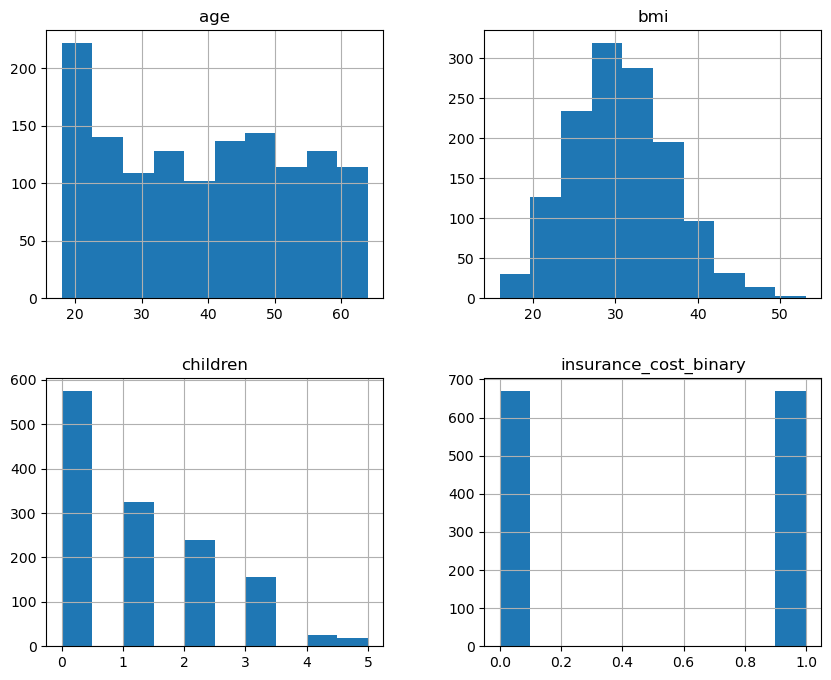

C:\Users\filcl\AppData\Local\Temp\ipykernel_19952\2079169010.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()  # Correlation matrix of the varibles - no correlations noted


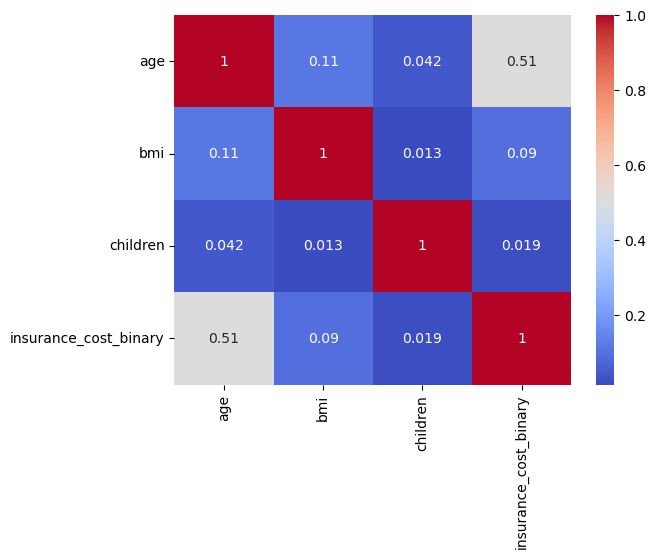

In [7]:
df.hist(figsize=(10, 8))  #Histogram of the numerical values above - data appears to be either uniformally or normally distributed
#age appears to be over represented at the younger age but no gaps in data
plt.show()


corr_matrix = df.corr()  # Correlation matrix of the varibles - no correlations noted
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()



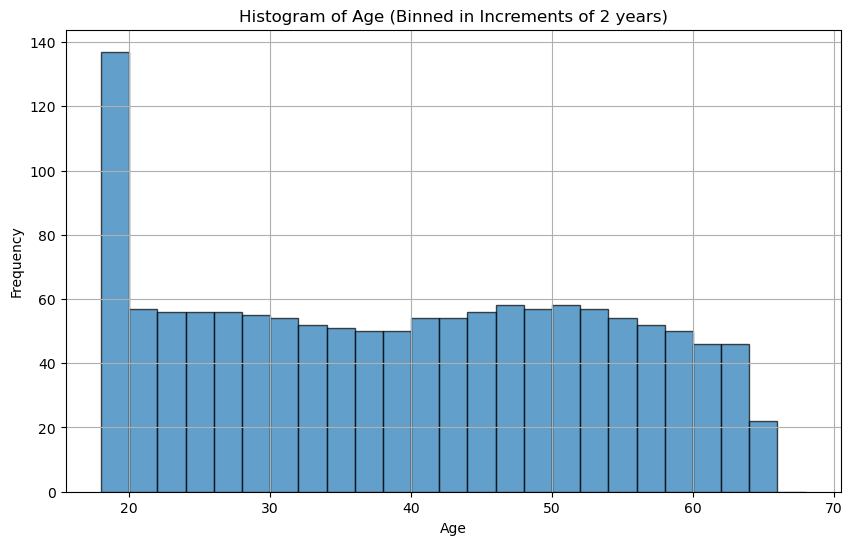

In [8]:
#Zooming in on age - twice the representation in the youngest
bin_range = range(df['age'].min(), df['age'].max() + 6, 2)

plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=bin_range, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age (Binned in Increments of 2 years)')
plt.grid(True)
plt.show()

# Section 1c Splitting Data to X and y

In [9]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Section 1d Transformers

In this section I set up my transformers that will be part of the data pipeline.  From the EDA I believe the appropriate transforms are:

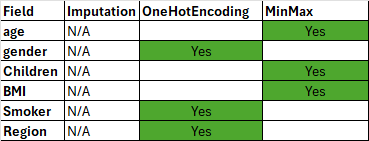


Which will give me two sets of transforms, one on the numerical and one on the categorical varibles with no imputation required on any variable.

In [10]:
#creating the transformers
ohe = OneHotEncoder(sparse_output=False, drop='first')
mscaler = MinMaxScaler()


In [11]:
#The columns broken down by transformer
columns_to_scale = ['children', 'bmi','age']
columns_to_onehotencode =['gender', 'region','smoker']

#the transformers
ct0 = ColumnTransformer(transformers=[('Scaler',mscaler, columns_to_scale)],remainder='passthrough')
ct1 = ColumnTransformer(transformers=[('OneHot',ohe, columns_to_onehotencode)],remainder='passthrough')



In [12]:
#the preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('ct0', ct0,columns_to_scale ),
        ('ct1', ct1, columns_to_onehotencode)],
    remainder='passthrough')

#saving it
joblib.dump(preprocessor, 'My_column_transformer_insurance.pkl')  #saving the preprocessor which is the point of the pipelines
#opening a view of it
preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('ct0',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('Scaler',
                                                                  MinMaxScaler(),
                                                                  ['children',
                                                                   'bmi',
                                                                   'age'])]),
                                 ['children', 'bmi', 'age']),
                                ('ct1',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('OneHot',
                                                                  OneHotEncoder(drop='first',
                                                                                sparse_output=False),
                                                                  ['gender',
                                                                   'region',
                                                                   'smoker'])]),
                                 ['gender', 'region', 'smoker'])])

# Section 1e Pipelines, Dimension Reduction and Models

# SVM

In [13]:
pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('reduce_dim', 'passthrough'),
    ('svm', svm.SVC(probability=True))
])

In [14]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct0',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('Scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['children',
                                                                                    'bmi',
                                                                                    'age'])]),
                                                  ['children', 'bmi', 'age']),
                                                 ('ct1',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OneHot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False),
                                                                                   ['gender',
                                                                                    'region',
                                                                                    'smoker'])]),
                                                  ['gender', 'region',
                                                   'smoker'])])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

In [15]:
N_FEATURES_OPTIONS = [2,3,4,5, 6,7, 8]
MAX_DEPTH_OPTIONS = [2, 3, 4, 5, 6,7, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'svm__C': [0.01,0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001 ], 
    'svm__kernel': ['rbf', 'linear', 'poly']},
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'svm__C': [0.01,0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001 ], 
    'svm__kernel': ['rbf', 'linear', 'poly']}
    ,
    {'reduce_dim': [SelectKBest(f_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,  
        'svm__C': [0.01,0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001 ], 
    'svm__kernel': ['rbf', 'linear', 'poly']}
  
  
    
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.944:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=7), 'reduce_dim__n_components': 7, 'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


# RF Classifier

In [16]:
# create the pipeline
pipe2 = Pipeline(steps=[('preprocess', preprocessor),('reduce_dim', 'passthrough'),('rf', RandomForestClassifier())])

In [17]:
set_config(display="diagram")
pipe2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct0',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('Scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['children',
                                                                                    'bmi',
                                                                                    'age'])]),
                                                  ['children', 'bmi', 'age']),
                                                 ('ct1',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OneHot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False),
                                                                                   ['gender',
                                                                                    'region',
                                                                                    'smoker'])]),
                                                  ['gender', 'region',
                                                   'smoker'])])),
                ('reduce_dim', 'passthrough'),
                ('rf', RandomForestClassifier())])

In [18]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90],
        'rf__max_depth': [2, 4, 6, 8, 9, 10, 11, 12]
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90],
        'rf__max_depth': [2, 4, 6, 8, 9, 10, 11, 12]
    },
    {'reduce_dim': [SelectKBest(f_classif)],
        'reduce_dim__k': [2,3,4,5,6,7,8],  
        'rf__n_estimators': [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90],
        'rf__max_depth': [2, 4, 6, 8, 9, 10, 11, 12]}
]
     
    
search = GridSearchCV(pipe2, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.946:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'rf__max_depth': 9, 'rf__n_estimators': 10}


# Logisitic Regression

In [19]:
# create the pipeline
pipe3 = Pipeline(steps=[('preprocess', preprocessor),('reduce_dim', 'passthrough'), ('lr', LogisticRegression())])


In [20]:
set_config(display="diagram")
pipe3

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct0',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('Scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['children',
                                                                                    'bmi',
                                                                                    'age'])]),
                                                  ['children', 'bmi', 'age']),
                                                 ('ct1',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OneHot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False),
                                                                                   ['gender',
                                                                                    'region',
                                                                                    'smoker'])]),
                                                  ['gender', 'region',
                                                   'smoker'])])),
                ('reduce_dim', 'passthrough'), ('lr', LogisticRegression())])

In [21]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'lr__penalty': ['l2'],
        'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'lr__penalty': ['l2'],
        'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    },
    {'reduce_dim': [SelectKBest(f_classif)],
        'reduce_dim__k': [2,3,4,5,6,7,8],  
        'lr__penalty': ['l2'],
        'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
]

search = GridSearchCV(pipe3, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
lr_best_params = search.best_params_
lr_best_model = search.best_estimator_

Best CV score = 0.931:
Best parameters:  {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg', 'reduce_dim': PCA(iterated_power=7, n_components=6), 'reduce_dim__n_components': 6}


# Naive Bayes

In [22]:
# create the pipeline
pipe4 = Pipeline(steps=[('preprocess', preprocessor),('reduce_dim', 'passthrough'), ('nb', BernoulliNB())])

In [23]:
set_config(display="diagram")
pipe4

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct0',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('Scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['children',
                                                                                    'bmi',
                                                                                    'age'])]),
                                                  ['children', 'bmi', 'age']),
                                                 ('ct1',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OneHot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False),
                                                                                   ['gender',
                                                                                    'region',
                                                                                    'smoker'])]),
                                                  ['gender', 'region',
                                                   'smoker'])])),
                ('reduce_dim', 'passthrough'), ('nb', BernoulliNB())])

In [24]:
param_grid =  [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
         'nb__alpha': [.01, 0.1, 0.5, 1.0, 2.0],  # Smoothing parameter alpha
        'nb__binarize': [0.0, 0.1, 0.2, 0.5,1]},
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'nb__alpha': [.01, 0.1, 0.5, 1.0, 2.0],  # Smoothing parameter alpha
        'nb__binarize': [0.0, 0.1, 0.2, 0.5,1]},
    
    {'reduce_dim': [SelectKBest(f_classif)],
        'reduce_dim__k': [2,3,4,5,6,7,8],  
       'nb__alpha': [.01, 0.1, 0.5, 1.0, 2.0],  # Smoothing parameter alpha
        'nb__binarize': [0.0, 0.1, 0.2, 0.5,1]}
]

search = GridSearchCV(pipe4, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
nb_best_params = search.best_params_
nb_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters:  {'nb__alpha': 0.01, 'nb__binarize': 0.2, 'reduce_dim': PCA(iterated_power=7, n_components=5), 'reduce_dim__n_components': 5}


# Neural Net

In [25]:
# Create the pipeline with the neural network classifier
pipe5 = Pipeline(steps=[('preprocess', preprocessor),('reduce_dim', 'passthrough'), ('nn', MLPClassifier())])

set_config(display="diagram")
pipe5

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct0',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('Scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['children',
                                                                                    'bmi',
                                                                                    'age'])]),
                                                  ['children', 'bmi', 'age']),
                                                 ('ct1',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OneHot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False),
                                                                                   ['gender',
                                                                                    'region',
                                                                                    'smoker'])]),
                                                  ['gender', 'region',
                                                   'smoker'])])),
                ('reduce_dim', 'passthrough'), ('nn', MLPClassifier())])

In [26]:
param_grid =param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'nn__hidden_layer_sizes': [(50),(50, 50), (100, 100), (50,50,5)],
        'nn__activation': ['relu', 'tanh', 'logistic'],
        'nn__alpha': [0.001, 0.01],
        #'nn__solver': ['adam', 'sgd'],  # Try different solvers
        'nn__max_iter': [1000]  # Increase max_iter
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'nn__hidden_layer_sizes': [(50),(50, 50), (100, 100), (50,50,5)],
        'nn__activation': ['relu', 'tanh', 'logistic'],
        'nn__alpha': [0.001, 0.01],
        #'nn__solver': ['adam', 'sgd'],  # Try different solvers
        'nn__max_iter': [1000]  # Increase max_iter
    },    
    {'reduce_dim': [SelectKBest(f_classif)],
        'reduce_dim__k': [2,3,4,5,6,7,8],  
       'nn__hidden_layer_sizes': [(50),(50, 50), (100, 100), (50,50,5)],
        'nn__activation': ['relu', 'tanh', 'logistic'],
        'nn__alpha': [0.001, 0.01],
        #'nn__solver': ['adam', 'sgd'],  # Try different solvers
        'nn__max_iter': [1000]}  # Increase max_iter
]

# Perform grid search
search = GridSearchCV(pipe5, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

# Print the best CV score and best parameters
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)



Best CV score = 0.955:
Best parameters:  {'nn__activation': 'tanh', 'nn__alpha': 0.001, 'nn__hidden_layer_sizes': (50, 50, 5), 'nn__max_iter': 1000, 'reduce_dim': SelectKBest(k=8), 'reduce_dim__k': 8}


In [27]:
# Store the best parameters and best model for later use
nn_best_params = search.best_params_
nn_best_model = search.best_estimator_

# Section 1F Model Comparison

In [28]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [36]:
def evaluate_model(X_test, y_test, model):
 
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [37]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
LR_accuracy, LR_precision, LR_recall, LR_f1_score, LR_tpr, LR_auc = evaluate_model(X_test, y_test, lr_best_model)
NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = evaluate_model(X_test, y_test, nb_best_model)
NN_accuracy, NN_precision, NN_recall, NN_f1_score, NN_tpr, NN_auc = evaluate_model(X_test, y_test, nn_best_model)

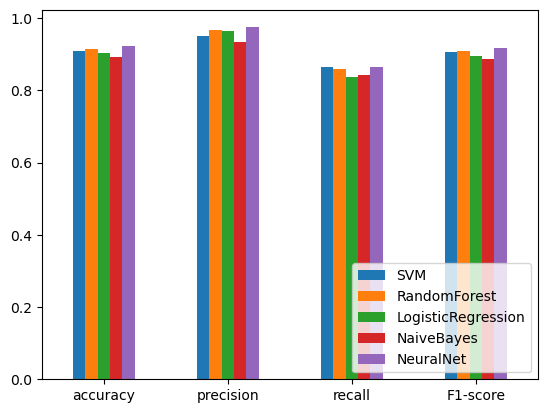

In [38]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
LR_metrics = np.array([LR_accuracy, LR_precision, LR_recall, LR_f1_score])
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])
NN_metrics = np.array([NN_accuracy, NN_precision, NN_recall, NN_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'RandomForest': RF_metrics, 'LogisticRegression': LR_metrics, 'NaiveBayes': NB_metrics, 'NeuralNet': NN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

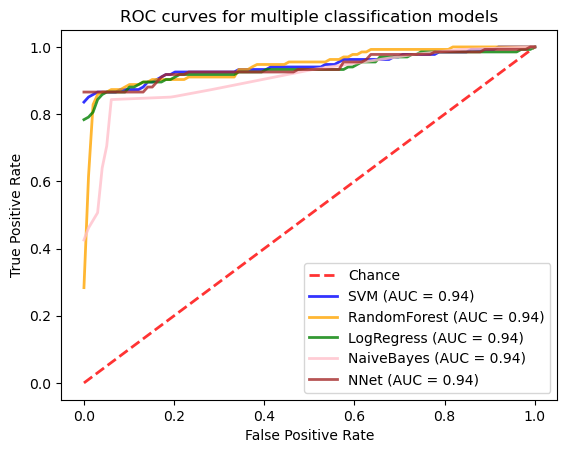

In [32]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='RandomForest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, LR_tpr[0,:], lw=2, color='green', label='LogRegress (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, NB_tpr[0,:], lw=2, color='pink', label='NaiveBayes (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, NN_tpr[0,:], lw=2, color='brown', label='NNet (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

## Section 1G Train the Final Model

In [35]:
# function to remove the string 'nn__' from the names of the parameters in nn_best_params


def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocessor, 
                     nn_best_params.get('reduce_dim'),
                     MLPClassifier(**transform(nn_best_params,'nn__')))

final_model =pipe.fit(X, y)
final_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct0',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('Scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['children',
                                                                                    'bmi',
                                                                                    'age'])]),
                                                  ['children', 'bmi', 'age']),
                                                 ('ct1',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OneHot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False),
                                                                                   ['gender',
                                                                                    'region',
                                                                                    'smoker'])]),
                                                  ['gender', 'region',
                                                   'smoker'])])),
                ('selectkbest', SelectKBest(k=8)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(50, 50, 5),
                               max_iter=1000))])

We can also store this model on disk and deploy later within a software system.

In [34]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Section 1H Conclusion

In this piece I carried out basic EDA, The data was in a good condition and did not require any imputation.  Onehot encoding and scaling was used.  I went with minmax scaling as I felt that the outliers were applicable were excessive and the distribution did not appear skewed.

The preprocessing pipelines were created to deal with the one hot encoding and scaling.
After that I looked at the Dimension reduction and feature selection, I went with select k best to satisfy the rubrix but could have utilised LDA, Dictionary Learningk t-SNE similarly.  I was expecting a similar return on the dimension reduction but some models settle on 5 being the best, others 7 and NN 8 for the best accuracy.  Obvsiously this is an impact of the models and other varibles being used.  Controlling for other variables and having run some basic models performance in terms of accuracy is degraded under n=4 features.

In terms of Models I utilised 5 in total in the pipelines.  SVM and RF were compariable at just over 94%.  Logistic regression and NB performed worse but still at a healtly 91% plus.  The winner was the NN, however it was the worst for training performance overall (not documented but experienced) so if that was a factor, SVM and RF were better options.

I was active on the forums this week, we were all consistent in our approaches although I feel I went further with the models.  Paul H did good work plotting the PCA feature affect on accuracy, which I choose not to replicate but learned from.

I would consider utilising Bayes search more than grid in future as with the 3 dimension reductions, CV and 5 models the volumes of model training became quite high.

__Rubrix Overview Classification__

Open a new Jupyter notebook and name it etivity3_classification.ipynb. __DONE__

In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. __DONE pre the pipeline to create a binary for the classification task__

Then train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`.  __DONE 5 models, SVM, RF, LogRegression, NB and NN__

Requirements:

For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.__DONE in all 5__

You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them. __DONE 5 Models__

For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.  __Done - Select K best was the third estimator.

Summarise your experience in a markdown cell (max 150 words in a markdown cell).  __DONE Above__